**Drew Tatum** <br>
**Final Project** <br>
**CSC 575 Intelligent Information Retrieval** <br>
**Winter 2021**

## DePaul Course Catalog Information Retrieval System

<ol>
    <li><a href=#Intro>Introduction</a></li>
    <li><a href=#WC>Web Crawler</a></li>
    <li><a href=#Index>Indexing</a></li>
    <li><a href=#Retrieval>Information Retrieval System</a></li>   
    <li><a href=#Test>Test Case</a></li>  
    <li><a href=#Results>Results</a></li>      
</ol>

In [4]:
# Modules
import requests
from bs4 import BeautifulSoup
import re
import json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import webbrowser  
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Introduction <a id=Intro>

The purpose of this project  to improve DePaul’s course information retrieval system from the perspective of a student taking courses at DePaul University. There are a few limitations right now that exist when using DePaul’s Campus Connect to search for courses to register. As of Winter 2021, queries that only match either the course ID or terms in the course’s title will return the course. For example, the query “SQL” will only return courses that have SQL within the course name regardless if the term is within the course description. Another limitation is the system uses an exact term match when searching its system. Since the current system doesn’t implement any type of stemming or lemmatization queries that are misspelled or are the plural form of a word like “regressions” won’t retrieve courses that have the term “regression” in it’s course title. One last notable restriction of the current retrieval system is that multiple topic’s can’t be searched at the same time. For example the query “SQL and Regression” looks for courses that both have SQL and regression within the course title. If no course exists, which is currently true, no courses are returned. Even though a few courses have regression and SQL within their course title separately, the current system isn’t able to provide the results the user desires. The goal of this information retrieval system is to help fix these current issues that are impacting student’s from exploring different courses and note of further potential development to improve their experience. Additionally the new information retrieval system implements a weighted similarity scheme based on the location of the queried term. For example, if the term appears in the course title it will be given a higher weighted value than terms appearing in the course description. This is based on the intuition that a course’s title will provide the main intellectual focus of the topic while the course description can provide topics that are briefly discussed. The objective of this weighing scheme is to provide the user results closer to their true desired query output. 

## Web Crawler <a id=WC>

In [2]:
##### Finding what courses to add to index based on Data Science Computational Methods program
data_science_url = 'https://www.cdm.depaul.edu/academics/Pages/Current/Requirements-MS-In-Data-Science-Computational-Methods.aspx'
url = requests.get(data_science_url)
soup = BeautifulSoup(url.content, 'html.parser')
class_ids = soup.find_all(class_='CDMExtendedCourseInfo')
additional_classes = soup.find_all(class_='manualSimplePopup')
all_ids = class_ids + additional_classes

course_ids = []
course_pattern = re.compile('>(.*)<')

for c_id in all_ids:
    name = re.findall(course_pattern, str(c_id))[0]
    if len(name) < 8 and name not in course_ids:  # len is to not include courses that aren't available anymore since 'no longer offered' appears with course id
        course_ids.append(name)
    
##### Web scraping each individual course
courses = {}
courseID_docID = {}  # CourseID mapping
for index, course in enumerate(course_ids):
    course_num = course[-3:]
    course_sub = course[:3].strip()
    course_url = 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=' + course_sub + '&CatalogNbr=' + course_num 
    # Update Mapping
    courseID_docID[int(index)] = {'Course ID': course, 'URL': course_url}
    # Each URL now has relevant course number and subject
    url = requests.get(course_url)
    
    # Parsing URL
    soup = BeautifulSoup(url.content, 'html.parser')
    name_results = soup.find_all(class_='PageTitle')
    info_results = soup.find_all('p')
    course_raw_info = info_results[1]
    # Course information and course name patterns
    info_pattern = re.compile('<p>\s+(.*)</p>')
    name_pattern = re.compile('"PageTitle">\s+(\w+)\s+(\d+):\s+(.+)<\/h1>')
    
    course_info = re.findall(info_pattern, str(course_raw_info))[0]
    course_name = re.findall(name_pattern, str(name_results))[0]
   
    course_id = course_name[0] + course_name[1]  # Course ID is the department + 3 number representation for the class
    course_topic = course_name[2]
        
    courses[course_id] = {'Topic': course_topic, 'Info': course_info}
    
    
# Saving json format of dictionary for further linguistic processing
with open('courses.json', 'w') as outfile:
    json.dump(courses, outfile)

with open('docID_mapping.json', 'w') as outfile2: # Dictionary with docID matching to course ID and url 
    json.dump(courseID_docID, outfile2)

The above code goes through DePaul's Data Science Computational Methods program and creates a list of each course ID and course number. With this each course is crawled and a dictionary caleld courses stores the course ID alongside with the course topic and course information. The course topic and course information are separated so that they can be processed differently since different term weights will be applied to them.

In [3]:
courses

{'IT403': {'Topic': 'Statistics and Data Analysis',
  'Info': 'Introduction to univariate data analysis methods. Descriptive statistics and data visualization methods. Overview of sampling techniques for data collection, and introduction to statistical inference methods for decision making including simple linear regression, estimation procedures using confidence intervals and hypothesis testing. PREREQUISITE(S): None'},
 'CSC412': {'Topic': 'Tools and Techniques for Computational Analysis',
  'Info': 'Use of mathematical software to explore basic concepts in linear algebra and calculus.  Scripting for symbolic and computational processing.  Emphasis is on applications in computer science, finance, data mining, and computer vision. PREREQUISITE(S): None'},
 'CSC401': {'Topic': 'Introduction to Programming',
  'Info': 'An introduction to programming with a focus on problem solving, structured programming, and algorithm design. Concepts covered include data types, expressions, variables,

Above is the output of the courses dictionary before linguistic processing.

In [4]:
courseID_docID

{0: {'Course ID': 'IT 403',
  'URL': 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=IT&CatalogNbr=403'},
 1: {'Course ID': 'CSC 412',
  'URL': 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=CSC&CatalogNbr=412'},
 2: {'Course ID': 'CSC 401',
  'URL': 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=CSC&CatalogNbr=401'},
 3: {'Course ID': 'DSC 450',
  'URL': 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=DSC&CatalogNbr=450'},
 4: {'Course ID': 'DSC 423',
  'URL': 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=DSC&CatalogNbr=423'},
 5: {'Course ID': 'DSC 424',
  'URL': 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=DSC&CatalogNbr=424'},
 6: {'Course ID': 'DSC 430',
  'URL': 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=DSC&CatalogNbr=430'},
 7: {'Course ID': 'DSC 441',
  'URL': 'https://www.cdm.depaul.edu/academics/pages/courseinfo.aspx?Subject=

Above is the document number and course ID mapping. This will be used to display results to the user. As seen above, there are 48 courses being used in this example.

## Indexing <a id=Index>

In [5]:
# Loading courses json file from web crawler
with open('courses.json', 'r') as infile:
    courses = json.load(infile)

##### Creating inverted index for Course Information 
info_inverted_index = []

##### Tokenization, Stop Word Removal, and Stemming for Course Information 
tokens_info = [word_tokenize(courses[key]['Info']) for key in courses.keys()]  # Tokens for course info
# Lowering each token, removing punctuation, removing stop words, and stemming
port_stemmer = PorterStemmer()
for doc_id, tokens_lst in enumerate(tokens_info):
    cleaned_tokens = [token.lower() for token in tokens_lst if token.isalpha() and token not in stopwords.words('english') and len(token) > 1]
    stemmed_tokens = [port_stemmer.stem(token) for token in cleaned_tokens]
    for token in stemmed_tokens:
        info_inverted_index.append([token, doc_id])

info_inverted_index = sorted(info_inverted_index)  # Sorting the inverted index

##### Creating index/dictionary and postings for course info
info_index = {}
info_postings = {}  # (docID, term frequency)
doc_id_lst = []  # Keep track of doc_id's for postings list
first_iteration = True 
count = 0
prev_docID = None
prev_term = None
for term, docID in info_inverted_index:
    if term not in info_index.keys():  # New term
        info_index[term] = {'Doc Freq': 1, 'Total Freq': 1}
        # Update postings list from prior
        if first_iteration == False:
            doc_id_lst.append([prev_docID, count])
            count = 0
            info_postings[prev_term] = doc_id_lst
            doc_id_lst = []
    else:  # Already added term
        if docID == prev_docID:  # Term is within same document
            info_index[term]['Total Freq'] += 1
        else:  # Term is in a new document
            info_index[term]['Doc Freq'] += 1
            info_index[term]['Total Freq'] += 1
            doc_id_lst.append((prev_docID, count))
            count = 0 
    count += 1
    prev_docID = docID  # Assigning docID as previous docID
    prev_term = term  # Assigning term as previous term
    first_iteration = False
# Adding last postings term 
doc_id_lst.append((prev_docID, count))
info_postings[prev_term] = doc_id_lst 
    

##### Saving info index and info postings as json files
with open('info_index.json', 'w') as outfile1:
    json.dump(info_index, outfile1)

with open('info_postings.json', 'w') as outfile2:
    json.dump(info_postings, outfile2)
    
    
##### Creating inverted index for Course Topic
topic_inverted_index = []

##### Tokenization, Stop Word Removal, and Stemming for Course Topic
tokens_info = [word_tokenize(courses[key]['Topic']) for key in courses.keys()]  # Tokens for course info
# Lowering each token, removing punctuation, removing stop words, and stemming
port_stemmer = PorterStemmer()
for doc_id, tokens_lst in enumerate(tokens_info):
    cleaned_tokens = [token.lower() for token in tokens_lst if token.isalpha() and token not in stopwords.words('english') and len(token) > 1]
    stemmed_tokens = [port_stemmer.stem(token) for token in cleaned_tokens]
    for token in stemmed_tokens:
        topic_inverted_index.append([token, doc_id])

topic_inverted_index = sorted(topic_inverted_index)  # Sorting the inverted index

##### Creating index/dictionary and postings for course topic
topic_index = {}
topic_postings = {}  # (docID, term frequency)
doc_id_lst = []  # Keep track of doc_id's for postings list
first_iteration = True 
count = 0
for term, docID in topic_inverted_index:
    if term not in topic_index.keys():  # New term
        topic_index[term] = {'Doc Freq': 1, 'Total Freq': 1}
        # Update postings list from prior
        if first_iteration == False:
            doc_id_lst.append([prev_docID, count])
            count = 0
            topic_postings[prev_term] = doc_id_lst
            doc_id_lst = []
    else:  # Already added term
        if docID == prev_docID:  # Term is within same document
            topic_index[term]['Total Freq'] += 1
        else:  # Term is in a new document
            topic_index[term]['Doc Freq'] += 1
            topic_index[term]['Total Freq'] += 1
            doc_id_lst.append((prev_docID, count))
            count = 0 
    count += 1
    prev_docID = docID  # Assigning docID as previous docID
    prev_term = term  # Assigning term as previous term
    first_iteration = False
    
# Adding last postings term 
doc_id_lst.append((prev_docID, count))
topic_postings[prev_term] = doc_id_lst 

# Saving topic index, topic postings, 
with open('topic_index.json', 'w') as outfile3:
    json.dump(topic_index, outfile3)

with open('topic_postings.json', 'w') as outfile4:
    json.dump(topic_postings, outfile4)

Above is the linguistic processing techniques that were applied to the bag of words. The terms were lower cased, stop words were removed, punctuation was removed, and a Porter Stemming algorithm was applied. An inverted index was created for the course topics and a separate inverted index was created for the course description. Each inverted index resulted in an index/dictionary and a postings list. All four of these files were saved to disk to be used by the information retrieval system.

In [6]:
topic_index

{'advanc': {'Doc Freq': 2, 'Total Freq': 2},
 'advertis': {'Doc Freq': 1, 'Total Freq': 1},
 'algorithm': {'Doc Freq': 1, 'Total Freq': 1},
 'analysi': {'Doc Freq': 9, 'Total Freq': 9},
 'analyt': {'Doc Freq': 4, 'Total Freq': 4},
 'appli': {'Doc Freq': 1, 'Total Freq': 1},
 'applic': {'Doc Freq': 1, 'Total Freq': 1},
 'artifici': {'Doc Freq': 1, 'Total Freq': 1},
 'big': {'Doc Freq': 2, 'Total Freq': 2},
 'busi': {'Doc Freq': 1, 'Total Freq': 1},
 'capston': {'Doc Freq': 1, 'Total Freq': 1},
 'carlo': {'Doc Freq': 1, 'Total Freq': 1},
 'commun': {'Doc Freq': 1, 'Total Freq': 1},
 'comput': {'Doc Freq': 3, 'Total Freq': 3},
 'custom': {'Doc Freq': 1, 'Total Freq': 1},
 'data': {'Doc Freq': 14, 'Total Freq': 14},
 'databas': {'Doc Freq': 3, 'Total Freq': 3},
 'deep': {'Doc Freq': 1, 'Total Freq': 1},
 'design': {'Doc Freq': 2, 'Total Freq': 2},
 'develop': {'Doc Freq': 2, 'Total Freq': 2},
 'digit': {'Doc Freq': 1, 'Total Freq': 1},
 'enterpris': {'Doc Freq': 1, 'Total Freq': 1},
 'expe

In [7]:
topic_postings

{'advanc': [(5, 1), [12, 1]],
 'advertis': [[25, 1]],
 'algorithm': [[13, 1]],
 'analysi': [(0, 1),
  (1, 1),
  (4, 1),
  (5, 1),
  (9, 1),
  (16, 1),
  (17, 1),
  (20, 1),
  [28, 1]],
 'analyt': [(3, 1), (36, 1), (40, 1), [41, 1]],
 'appli': [[20, 1]],
 'applic': [[10, 1]],
 'artifici': [[27, 1]],
 'big': [(11, 1), [33, 1]],
 'busi': [[36, 1]],
 'capston': [[43, 1]],
 'carlo': [[13, 1]],
 'commun': [[29, 1]],
 'comput': [(1, 1), (22, 1), [25, 1]],
 'custom': [[39, 1]],
 'data': [(0, 1),
  (4, 1),
  (5, 1),
  (7, 1),
  (8, 1),
  (11, 1),
  (17, 1),
  (21, 1),
  (23, 1),
  (28, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  [43, 1]],
 'databas': [(3, 1), (18, 1), [24, 1]],
 'deep': [[15, 1]],
 'design': [(31, 1), [46, 1]],
 'develop': [(29, 1), [30, 1]],
 'digit': [[41, 1]],
 'enterpris': [[35, 1]],
 'experi': [[46, 1]],
 'forecast': [[16, 1]],
 'fundament': [[7, 1]],
 'geograph': [(24, 1), (29, 1), [30, 1]],
 'gi': [(29, 1), [30, 1]],
 'graduat': [[44, 1]],
 'health': [(23, 1), [37, 1]],
 'ima

In [10]:
print('Terms in course description: {}'.format(len(info_index)))
print('Terms in course title: {}'.format(len(topic_postings)))

Terms in course description: 682
Terms in course title: 75


## Information Retrieval System <a id=Retrieval>

In [11]:
# Loading info index, info postings, and docID_mapping from indexing
with open('info_index.json', 'r') as infile1:
    info_index = json.load(infile1)
    
with open('info_postings.json', 'r') as infile2:
    info_postings = json.load(infile2)

with open('docID_mapping.json', 'r') as infile3:
    docID_mapping = json.load(infile3)

# Loading topic index, and topic postings
with open('topic_index.json', 'r') as infile4:
    topic_index = json.load(infile4)
    
with open('topic_postings.json', 'r') as infile5:
    topic_postings = json.load(infile5)

class QueryRetrieval:
    def __init__(self, info_index, info_postings, topic_index, topic_postings, mapping, k, d, topic_weight):
        # Info is the course description while topic is the course name 
        self.info_index = info_index  
        self.info_postings = info_postings
        self.topic_index = topic_index
        self.topic_postings = topic_postings
        self.mapping = mapping 
        self.N = len(mapping)
        self.k = k  # Number of retrieved docs based on cosine similarity 
        self.d = d  # Top d documents returned to user 
        self.topic_weight = topic_weight  # Weight of the topic name keywords similarity (Course info weight is 1-topic_weight)
    
    def RetrieveDocs(self, query):
        """Retrieves top 3 Doc URL's based on User Query"""
        self.query = str(query)
        # Obtaining IDF Weights
        info_idf_weights = self.IDF(info_index) 
        topic_idf_weights = self.IDF(self.topic_index) 
        # Creating vector space model of postings matrix
        info_posting_matrix = self.VectorSpace(self.info_postings)
        topic_posting_matrix = self.VectorSpace(self.topic_postings) 
        # Normalizing vector space model
        normalized_info_matrix = self.TFIDF(info_idf_weights, info_posting_matrix)
        normalized_topic_matrix = self.TFIDF(topic_idf_weights, topic_posting_matrix)
        # Tokenizing query and linguistic processing 
        tokenized_query = self.QueryTokens()
        # Vector representation of the query
        info_vector_query = self.QueryVector(tokenized_query, self.info_postings)
        topic_vector_query = self.QueryVector(tokenized_query, self.topic_postings)
        # Calculating Similarity Values 
        info_sim_list = self.CosineSimilarity(normalized_info_matrix, info_vector_query)
        topic_sim_list = self.CosineSimilarity(normalized_topic_matrix, topic_vector_query)
        # Computing Weighted Similarity Value 
        query_docs = self.DocRetrieval(info_sim_list, topic_sim_list)
        # Opens top d document URLs to user
        for doc_id, sim in query_docs:
            course_URL = self.mapping[str(doc_id)]['URL']
            webbrowser.open(course_URL)
    
    def QueryTokens(self):
        """Tokenizes the Query Based on the Rules for the Document Index and Posting Tokenization"""
        modified_query = []
        tokens_query = word_tokenize(self.query)  # Tokens of the query
        modified_query = []
        port_stemmer = PorterStemmer()
        for token in tokens_query:
            if token.isalpha() and token not in stopwords.words('english'):  # Removing stop words and punctuation 
                modified_query.append(port_stemmer.stem(token))  # Stemming the tokens
        
        return modified_query
    
    def QueryVector(self, token_query, postings):
        """Returns a Vector Representation of the Query Using the Postings List"""
        vector = np.zeros(len(postings))
        for term in token_query:  # Iterating through each query term
            for index, key in enumerate(postings.keys()):  # Iterating through the term dictionary, aka the keys
                if term == key:  # Finding when the query term matches the dictionary
                    vector[index] += 1  # Adding a one to the vector location
        return vector
        
    def IDF(self, index):
        """Returns IDF Weights for the Index"""
        idf_lst = []
        for term in index.keys():
            idf_weight = np.log2(self.N/index[term]['Doc Freq']) # using log2
            idf_lst.append(idf_weight)
        return idf_lst            

    def TFIDF(self, idf_vals, non_normalized_matrix):
        """Calculates the normalized postings list using TF*IDF Weights"""
        non_normalized_matrix = np.transpose(non_normalized_matrix)
        normalized_matrix = []
        for row in range(len(idf_vals)):
            new_val = np.round(idf_vals[row] * non_normalized_matrix[row], 3) # IDF * TF for each term as an array
            normalized_val = np.round(np.sqrt(sum(idf_vals[row]**2 * non_normalized_matrix[row]**2)),3)  # Normalizing the value 
            normalized_matrix.append(new_val/normalized_val)
        normalized_matrix = np.transpose(normalized_matrix)
    
        return normalized_matrix
     
    def VectorSpace(self, postings):
        """Vector Space Representation of the Postings List"""
        # Sparse Empty Matrix
        df = pd.DataFrame(columns = postings.keys(), index=list(range(self.N)))
        df.fillna(value=0, inplace=True)  # Creating sparse matrix of zeros
        
        for term in postings.keys():  # Iterating through each term in postings list (key)
            for occurence in postings[term]:  # Obtaining docID and freq for each term
                doc_num = occurence[0]
                term_freq = occurence[1]
                df.at[doc_num, term] += term_freq  # Updating term frequency 

        return np.array(df)  # Returning numpy array of df

    def CosineSimilarity(self, posting_matrix, vector_query):
        """Calculates the Cosine Similarity between each Document Vector and the Query Vector. Returns Top K Similar Documents"""
        cosine_sim_list = []
        for docID, doc in enumerate(posting_matrix):
            dot_prod = np.dot(doc, vector_query)
            x_norm = 0
            y_norm = 0
            
            for val in doc:
                x_norm += val**2
            
            for val in vector_query:
                y_norm += val**2
            
            if x_norm * y_norm != 0:  # Catch dot prod zero errors where no terms appear
                cosine_similarity_val = round(dot_prod/(np.sqrt(x_norm * y_norm)), 3)        
                cosine_sim_list.append([cosine_similarity_val, docID])
    
        sorted_list = sorted(cosine_sim_list, reverse=True)
        return sorted_list[0:self.k]  

    def DocRetrieval(self, info_similarity, topic_similarity):
        """Returns the Top D Courses to the Items Based on the Weighted Similarity Measure between Topic and Info of the course"""
        info_weight = 1 - self.topic_weight
        topic_weight = self.topic_weight
        
        combined_sim_dic = {}
        
        for similarity in info_similarity: 
            doc_id = similarity[1]
            sim_val = similarity[0] * info_weight
            combined_sim_dic[doc_id] = sim_val
            
        for similarity in topic_similarity:  
            doc_id = similarity[1]
            sim_val = similarity[0] * topic_weight
            if doc_id not in combined_sim_dic.keys():
                combined_sim_dic[doc_id] = sim_val
            else:
                combined_sim_dic[doc_id] += sim_val
        
        return list(sorted(combined_sim_dic.items(), key=lambda item: item[1], reverse=True))[0:self.d]

Above is the code for the information retrieval system. The information retrieval system takes a query and uses the same linguistic preprocessing techniques. Using the index and postings list a vector space model is created for both the course description and course title. Both of these separate vector spaces use a normalized TFxIDF weighting. The query is also represented in a vector space. This allow for Cosine Similarity to be measured between the query and each document. Each vector space model returns k number of similar documents. The weighted cosine score is calculated based on the course topic weight. Afterwards d number of documents are returned to the user by opening the course webpage in the web browser of the user. 

In [13]:
k = 10  # Number of Similar Documents Returned to Weighting System
d = 3  # Number of Documents Displayed to User
topic_weight = .2  # Weight for the course name (Course description weight is 1-topic_weight)
x = QueryRetrieval(info_index, info_postings, topic_index, topic_postings, docID_mapping, k, d, topic_weight)      
x.RetrieveDocs('Regression SQL')

In [14]:
x.RetrieveDocs('Regressions')

In [15]:
x.RetrieveDocs('Mining')

As seen above by these three trials it helps eliminate the three limitations as noted above in the introduction.

## Test  Case <a id=Test>

In [17]:
### MedLine Collection http://ir.dcs.gla.ac.uk/resources/test_collections/medl/
### Chosen because there is an article title and description 
#### Reading in the files
# Documents
raw_data = {}  # Will hold the raw form of each document
doc_id = 0
first_iteration = True
with open('./ML/MED.ALL') as infile:
    new_doc = []
    x = infile.readlines()
    for line in x:
        txt = line.strip()
        first_two = txt[:2]
        if first_two == '.I':  # Marks a new document
            if first_iteration == False:
                raw_data[doc_id] = ' '.join(new_doc)
                new_doc = []
                doc_id += 1
            else:
                first_iteration = False
                doc_id += 1
        elif len(txt) == 2:
            pass
        else:
            new_doc.append(txt)
            
    raw_data[doc_id] = ' '.join(new_doc)

# Creating a Topic Dictionary (Article title)
# Creating a Info Dictionary (Article description)
topic_dict = {}  # Will hold the article titles for each document
info_dict = {}  # Will hold the article description for each document 
for key in raw_data.keys():
    description = []
    val = raw_data[key]
    sentences = val.split('.')
    for index, sentence in enumerate(sentences):
        if index == 0:  # First sentence is the article topic
            topic_dict[key] = sentence
        else:  # All other sentences are the article description 
            description += [sentence]
    info_dict[key] = ' '.join(description)
    

# Queries
raw_queries = {}  # Will hold each query 
query_id = 0
first_iteration = True
with open('./ML/MED.QRY') as infile:
    new_query = []
    x = infile.readlines()
    for line in x:
        txt = line.strip()
        if len(txt) == 4 or len(txt) == 5:
            if first_iteration == False:
                raw_queries[query_id] = ' '.join(new_query)
                new_query = []
                query_id += 1
            else:
                first_iteration = False
                query_id += 1
        elif len(txt) == 2:
            pass
        else:
            new_query.append(txt)
            
    raw_queries[query_id] = ' '.join(new_query)

### Tokenization according to project model (Using the same process that was peformed for the course catalog project)
### Only changed the lines with tokens_info variable (2 lines) to get each dictionary accordingly to new name 

##### Creating inverted index for Course Information 
info_inverted_index = []

##### Tokenization, Stop Word Removal, and Stemming for Article Description
tokens_info = [word_tokenize(info_dict[key]) for key in info_dict.keys()]  # Tokens for Article Description
# Lowering each token, removing punctuation, removing stop words, and stemming
port_stemmer = PorterStemmer()
for doc_id, tokens_lst in enumerate(tokens_info):
    cleaned_tokens = [token.lower() for token in tokens_lst if token.isalpha() and token not in stopwords.words('english') and len(token) > 1]
    stemmed_tokens = [port_stemmer.stem(token) for token in cleaned_tokens]
    for token in stemmed_tokens:
        info_inverted_index.append([token, doc_id])

info_inverted_index = sorted(info_inverted_index)  # Sorting the inverted index

##### Creating index/dictionary and postings for course description 
info_index = {}
info_postings = {}  # (docID, term frequency)
doc_id_lst = []  # Keep track of doc_id's for postings list
first_iteration = True 
count = 0
prev_docID = None
prev_term = None
for term, docID in info_inverted_index:
    if term not in info_index.keys():  # New term
        info_index[term] = {'Doc Freq': 1, 'Total Freq': 1}
        # Update postings list from prior
        if first_iteration == False:
            doc_id_lst.append([prev_docID, count])
            count = 0
            info_postings[prev_term] = doc_id_lst
            doc_id_lst = []
    else:  # Already added term
        if docID == prev_docID:  # Term is within same document
            info_index[term]['Total Freq'] += 1
        else:  # Term is in a new document
            info_index[term]['Doc Freq'] += 1
            info_index[term]['Total Freq'] += 1
            doc_id_lst.append((prev_docID, count))
            count = 0 
    count += 1
    prev_docID = docID  # Assigning docID as previous docID
    prev_term = term  # Assigning term as previous term
    first_iteration = False
# Adding last postings term 
doc_id_lst.append((prev_docID, count))
info_postings[prev_term] = doc_id_lst     
    
##### Creating inverted index for Article Topic
topic_inverted_index = []

##### Tokenization, Stop Word Removal, and Stemming for Course Topic
tokens_info = [word_tokenize(topic_dict[key]) for key in topic_dict.keys()]  # Tokens for course info
# Lowering each token, removing punctuation, removing stop words, and stemming
port_stemmer = PorterStemmer()
for doc_id, tokens_lst in enumerate(tokens_info):
    cleaned_tokens = [token.lower() for token in tokens_lst if token.isalpha() and token not in stopwords.words('english') and len(token) > 1]
    stemmed_tokens = [port_stemmer.stem(token) for token in cleaned_tokens]
    for token in stemmed_tokens:
        topic_inverted_index.append([token, doc_id])

topic_inverted_index = sorted(topic_inverted_index)  # Sorting the inverted index

##### Creating index/dictionary and postings for course topic
topic_index = {}
topic_postings = {}  # (docID, term frequency)
doc_id_lst = []  # Keep track of doc_id's for postings list
first_iteration = True 
count = 0
for term, docID in topic_inverted_index:
    if term not in topic_index.keys():  # New term
        topic_index[term] = {'Doc Freq': 1, 'Total Freq': 1}
        # Update postings list from prior
        if first_iteration == False:
            doc_id_lst.append([prev_docID, count])
            count = 0
            topic_postings[prev_term] = doc_id_lst
            doc_id_lst = []
    else:  # Already added term
        if docID == prev_docID:  # Term is within same document
            topic_index[term]['Total Freq'] += 1
        else:  # Term is in a new document
            topic_index[term]['Doc Freq'] += 1
            topic_index[term]['Total Freq'] += 1
            doc_id_lst.append((prev_docID, count))
            count = 0 
    count += 1
    prev_docID = docID  # Assigning docID as previous docID
    prev_term = term  # Assigning term as previous term
    first_iteration = False
    
# Adding last postings term 
doc_id_lst.append((prev_docID, count))
topic_postings[prev_term] = doc_id_lst 

##### RECAP
# Have the following 4 dictionaries 
## Two Indexes: info_index, topic_index
## Two Postings: info_postings, topic_postings


##### Saving info index and info postings as json files
with open('test_info_index.json', 'w') as outfile1:
    json.dump(info_index, outfile1)

with open('test_info_postings.json', 'w') as outfile2:
    json.dump(info_postings, outfile2)

# Saving topic index, topic postings, 
with open('test_topic_index.json', 'w') as outfile3:
    json.dump(topic_index, outfile3)

with open('test_topic_postings.json', 'w') as outfile4:
    json.dump(topic_postings, outfile4)

Above is the code used to test my information retrieval system using a collection of documents from MedLine. The MedLine corpus has 1,003 documents and 30 test queries alongside with it's relevant documents. This test corpus was used since it contains the article's title and article's description for all 1,003 documents. This allowed me to test different weighting schemes to see which one might work well with my information retrieval system. Above the documents went through the same pre-processing schemes as above. Also, two inverted indexes were also created each resulting in it's own index/dictionary and postings list.

In [18]:
print('Terms in article description: {}'.format(len(info_index)))
print('Terms in article title: {}'.format(len(topic_postings)))

Terms in article description: 7669
Terms in article title: 2534


In comparison to my information retrieval system, this corpus has a significantly larger number of terms.

In [9]:
# Queries
raw_queries = {}  # Will hold each query 
query_id = 0
first_iteration = True
with open('./ML/MED.QRY') as infile:
    new_query = []
    x = infile.readlines()
    for line in x:
        txt = line.strip()
        if len(txt) == 4 or len(txt) == 5:
            if first_iteration == False:
                raw_queries[query_id] = ' '.join(new_query)
                new_query = []
                query_id += 1
            else:
                first_iteration = False
                query_id += 1
        elif len(txt) == 2:
            pass
        else:
            new_query.append(txt)
            
    raw_queries[query_id] = ' '.join(new_query)


# Loading info index, info postings, 
with open('test_info_index.json', 'r') as infile1:
    info_index = json.load(infile1)
    
with open('test_info_postings.json', 'r') as infile2:
    info_postings = json.load(infile2)

# Loading topic index, and topic postings
with open('test_topic_index.json', 'r') as infile3:
    topic_index = json.load(infile3)
    
with open('test_topic_postings.json', 'r') as infile4:
    topic_postings = json.load(infile4)


### Testing the Information Retrieval System

class TestQueryRetrieval:
    def __init__(self, info_index, info_postings, topic_index, topic_postings, k, d, topic_weight):
        # Info is the course description while topic is the course name 
        self.info_index = info_index  
        self.info_postings = info_postings
        self.topic_index = topic_index
        self.topic_postings = topic_postings
        self.N = 1033  # Number of docs 
        self.k = k  # Number of retrieved docs based on cosine similarity 
        self.d = d  # Top d documents returned to user 
        self.topic_weight = topic_weight  # Weight of the topic name keywords similarity (Course info weight is 1-topic_weight)
    
    def RetrieveDocs(self, query):
        """Retrieves top 3 Doc URL's based on User Query"""
        self.query = str(query)
        # Obtaining IDF Weights
        info_idf_weights = self.IDF(info_index) 
        topic_idf_weights = self.IDF(self.topic_index) 
        # Creating vector space model of postings matrix
        info_posting_matrix = self.VectorSpace(self.info_postings)
        topic_posting_matrix = self.VectorSpace(self.topic_postings) 
        # Normalizing vector space model
        normalized_info_matrix = self.TFIDF(info_idf_weights, info_posting_matrix)
        normalized_topic_matrix = self.TFIDF(topic_idf_weights, topic_posting_matrix)
        # Tokenizing query and linguistic processing 
        tokenized_query = self.QueryTokens()
        # Vector representation of the query
        info_vector_query = self.QueryVector(tokenized_query, self.info_postings)
        topic_vector_query = self.QueryVector(tokenized_query, self.topic_postings)
        # Calculating Similarity Values 
        info_sim_list = self.CosineSimilarity(normalized_info_matrix, info_vector_query)
        topic_sim_list = self.CosineSimilarity(normalized_topic_matrix, topic_vector_query)
        # Computing Weighted Similarity Value 
        query_docs = self.DocRetrieval(info_sim_list, topic_sim_list)
        # Returns tuple with docID, similarity value to the user sorted by similarity value for top d documents
        return query_docs 

    
    def QueryTokens(self):
        """Tokenizes the Query Based on the Rules for the Document Index and Posting Tokenization"""
        modified_query = []
        tokens_query = word_tokenize(self.query)  # Tokens of the query
        modified_query = []
        port_stemmer = PorterStemmer()
        for token in tokens_query:
            if token.isalpha() and token not in stopwords.words('english'):  # Removing stop words and punctuation 
                modified_query.append(port_stemmer.stem(token))  # Stemming the tokens
        
        return modified_query
    
    def QueryVector(self, token_query, postings):
        """Returns a Vector Representation of the Query Using the Postings List"""
        vector = np.zeros(len(postings))
        for term in token_query:  # Iterating through each query term
            for index, key in enumerate(postings.keys()):  # Iterating through the term dictionary, aka the keys
                if term == key:  # Finding when the query term matches the dictionary
                    vector[index] += 1  # Adding a one to the vector location
        return vector
        
    def IDF(self, index):
        """Returns IDF Weights for the Index"""
        idf_lst = []
        for term in index.keys():
            idf_weight = np.log2(self.N/index[term]['Doc Freq']) # using log2
            idf_lst.append(idf_weight)
        return idf_lst            

    def TFIDF(self, idf_vals, non_normalized_matrix):
        """Calculates the normalized postings list using TF*IDF Weights"""
        non_normalized_matrix = np.transpose(non_normalized_matrix)
        normalized_matrix = []
        for row in range(len(idf_vals)):
            new_val = np.round(idf_vals[row] * non_normalized_matrix[row], 3) # IDF * TF for each term as an array
            normalized_val = np.round(np.sqrt(sum(idf_vals[row]**2 * non_normalized_matrix[row]**2)),3)  # Normalizing the value 
            normalized_matrix.append(new_val/normalized_val)
        normalized_matrix = np.transpose(normalized_matrix)
    
        return normalized_matrix
     
    def VectorSpace(self, postings):
        """Vector Space Representation of the Postings List"""
        # Sparse Empty Matrix
        df = pd.DataFrame(columns = postings.keys(), index=list(range(self.N)))
        df.fillna(value=0, inplace=True)  # Creating sparse matrix of zeros
        
        for term in postings.keys():  # Iterating through each term in postings list (key)
            for occurence in postings[term]:  # Obtaining docID and freq for each term
                doc_num = occurence[0]
                term_freq = occurence[1]
                df.at[doc_num, term] += term_freq  # Updating term frequency 

        return np.array(df)  # Returning numpy array of df

    def CosineSimilarity(self, posting_matrix, vector_query):
        """Calculates the Cosine Similarity between each Document Vector and the Query Vector. Returns Top K Similar Documents"""
        cosine_sim_list = []
        for docID, doc in enumerate(posting_matrix):
            dot_prod = np.dot(doc, vector_query)
            x_norm = 0
            y_norm = 0
            
            for val in doc:
                x_norm += val**2
            
            for val in vector_query:
                y_norm += val**2
            
            if x_norm * y_norm != 0:  # Catch dot prod zero errors where no terms appear
                cosine_similarity_val = round(dot_prod/(np.sqrt(x_norm * y_norm)), 3)        
                cosine_sim_list.append([cosine_similarity_val, docID])
    
        sorted_list = sorted(cosine_sim_list, reverse=True)
        return sorted_list[0:self.k]  

    def DocRetrieval(self, info_similarity, topic_similarity):
        """Returns the Top D Courses to the Items Based on the Weighted Similarity Measure between Topic and Info of the course"""
        info_weight = 1 - self.topic_weight
        topic_weight = self.topic_weight
        
        combined_sim_dic = {}
        
        for similarity in info_similarity: 
            doc_id = similarity[1]
            sim_val = similarity[0] * info_weight
            combined_sim_dic[doc_id] = sim_val
            
        for similarity in topic_similarity:  
            doc_id = similarity[1]
            sim_val = similarity[0] * topic_weight
            if doc_id not in combined_sim_dic.keys():
                combined_sim_dic[doc_id] = sim_val
            else:
                combined_sim_dic[doc_id] += sim_val
        
        return list(sorted(combined_sim_dic.items(), key=lambda item: item[1], reverse=True))[0:self.d]

In [10]:
#k = 10  # Number of Similar Documents Returned to Weighting System
#d = 8  # Number of Documents Displayed to User (Query #12 only has 9 relevant docs, so only retrieving 8 for each one.)
# Different Topic Weights to Test
#topic_weight_lst = np.arange(.2, .8, .1)  # Weight for the course name (Course description weight is 1-topic_weight)

# Testing the System on the Queries with Different Weights 
#results = pd.DataFrame(columns = ['Topic Weight', 'Query #', 'Doc ID'])
#for topic_weight in topic_weight_lst:
#    x = TestQueryRetrieval(info_index, info_postings, topic_index, topic_postings, k, d, topic_weight)    
#    for key in raw_queries.keys():
#        query = raw_queries[key]
#        retrieved_docs = x.RetrieveDocs(query)
#        for docID, sim_val in retrieved_docs:
#            results = results.append({'Topic Weight': round(topic_weight, 1), 'Query #': key, 'Doc ID': docID}, ignore_index = True)

# Saving results to csv file
#results.to_csv('test_results.csv', index=False)  

Above is the code used to test different article topic weights for each 30 queries. Topic weights from .2 to .8 were tested while retrieving the top 8 documents from the system. The results were saved in a pandas dataframe and later saved to the test_results.csv. Since the testing of the system took a significant amount of time, it might be best to comment out the above code chunk is the test_result.csv file is saved in the same directory as this file.

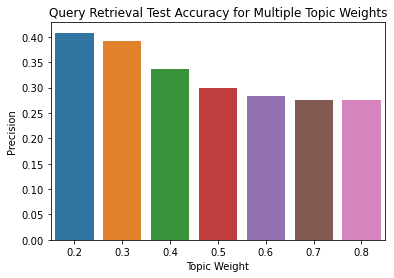

In [11]:
# Relevance from http://ir.dcs.gla.ac.uk/resources/test_collections/medl/
columns=['Query', 'Doc ID'] 
df = pd.read_table('./ML/MED.REL', sep=' ', header=None, usecols=[0,2])  # Holds the query ID and it's relevant doc IDs
df.columns = columns

# Results from system_test_query.py
results = pd.read_csv('test_results.csv')
topic_weights_lst = results['Topic Weight'].unique()

# Going through the results and counting how many times the returned document was relevant according the MedLine test collection 
n_queries = 30
n_retrieved = 8
final_results = {}
for query_num in range(1, n_queries+1):
    ## Looking in dataframe for the specific query
    query_df = results[results['Query #'] == query_num]
    for weight in topic_weights_lst:  # Going through each weighting scheme
        relevant_count = 0
        weight = round(weight,1)
        weight_df = query_df[query_df['Topic Weight'] == weight]
        returned_documents = weight_df['Doc ID'].values  # Getting the documents the system returned 
        # Check if the document is relevant 
        relevant_query = df[df['Query'] == query_num]
        relevant_docs = relevant_query['Doc ID'].values
        
        for doc in returned_documents:  # Looping through returned documents by system
            if doc in relevant_docs:  # Checking if document was part of the relevant collection 
                relevant_count += 1
        
        # Updating results (Results are the term weight with the total number of relevant returned documents)
        if weight not in final_results.keys():
            final_results[weight] = relevant_count
        else:
            final_results[weight] += relevant_count

        
x = []  # Term Weights
y = []  # Precision
for key in final_results.keys():
    x.append(key)
    y.append(final_results[key]/(n_queries*n_retrieved))  # Dividing by number of queries and number of documents returned to get precision


# Plot of the results 
sns.barplot(x= x, y=y)
plt.xlabel('Topic Weight')
plt.ylabel('Precision')
plt.title('Query Retrieval Test Accuracy for Multiple Topic Weights')
plt.savefig('weights_image.png')
plt.show()

Above is a display of the results obtained from the MedLine testing data. As seen above a topic weight of .2 resulted in the highest precision value of 41%. 

## Results <a id=Results>

The results and implementation of this information retrieval system resulted in a course retrieval system without any of the three limitations mentioned above. The system was able to provide courses relevant to the user using a weighted similarity measurement based on the course’s name and description. Additionally it offered the ability to search multiple topics and provide relevant information about them. That being said there still are a few limitations for further development. One big limitation is the sample size of the documents. For now the course’s indexed are ones only part of that are in the Data Science Computational Methods course catalog. Also, there is no way to filter the courses based on the time of the year the class is offered or for keyword analysis on different synonyms or similar phrases. Further research needs to be done to validate the appropriate value for the course topic weight parameter. Relevance feedback could be used in the future to help approximate this value. Future steps include creating a server side for the index/dictionary and postings list based on their relational database structure. 